In [ ]:
# Code+ Campus Space & Energy Project
# Dates: July 15-19, 2024.
# Team member: Adeildo Vieira

In [5]:
#### Brainstorm:

# CO2 research:

# Normalization of CO2 data:
# Check if there's a similarity in the RoC/SqFt
# in our room and then check 127.
# Maximum legal # of people per room (Maximum Occ); Avg occupancy; Minimum.
# Instead of numeric, specific occupancy, we would do maximum/average/minimum per room.

# Occupancy:
# Divide the Two Pis concentration of the analyzis in the same room.
# Analyze RoC PjRm1 -> Compare it to RoC 127
# Check occupancy PjRm1 -> Check occupancy 127

In [ ]:
#### DATA:

## Room measurements:

# Room 133:
    # Area, 147 sqft;
    # Height, 8ft 1in;
    ## VOLUME --- 1188.25 cubic feet.

# Room 127:
    # Area, 1042 sqft;
    # Height, 11ft 4in.
    ## VOLUME --- 11,809.33 cubic feet.

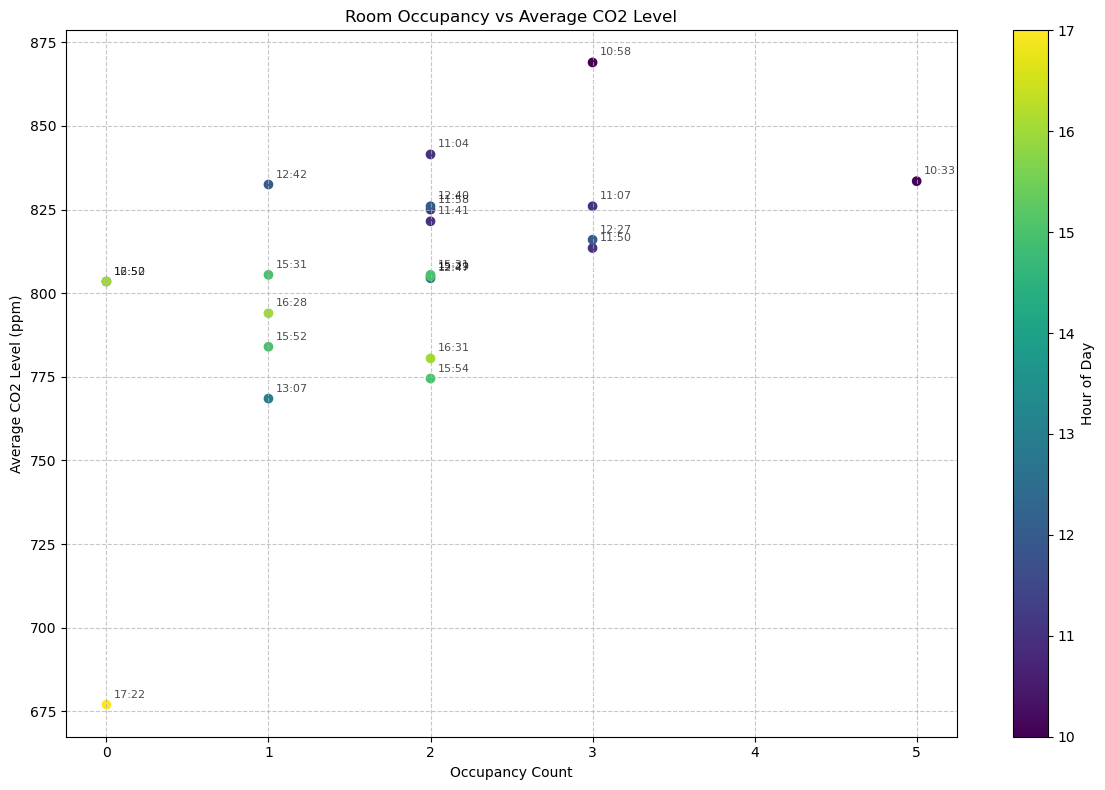

Correlation coefficient between Occupancy and Average CO2: 0.54


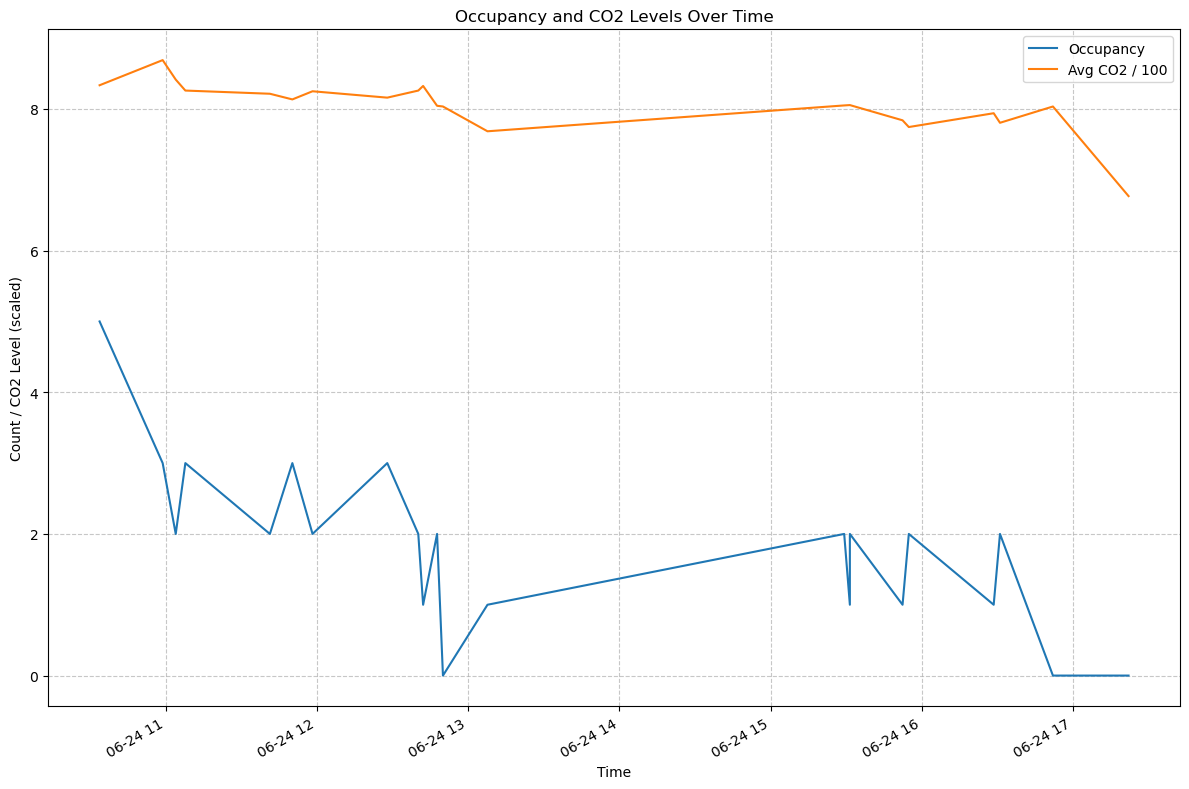

In [7]:
#### BEFORE THE FIRST APPROACH:

## Room 133
## Visualize CO2 data:

import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Load the data
occupancy_data = pd.read_csv('24th_occupancy_dataSheet1.csv', parse_dates=['Time'])
co2_data_pi1 = pd.read_csv('co2_data_24th_pi1.csv', parse_dates=['timestamp'])
co2_data_pi2 = pd.read_csv('co2_data_24th_pi2.csv', parse_dates=['timestamp'])

# Function to find the closest CO2 reading for a given timestamp
def find_closest_co2(row, co2_data):
    closest = co2_data.loc[(co2_data['timestamp'] - row['Time']).abs().idxmin()]
    return closest['co2']

# Add CO2 readings from both Pi sensors to the occupancy data
occupancy_data['CO2_Pi1'] = occupancy_data.apply(lambda row: find_closest_co2(row, co2_data_pi1), axis=1)
occupancy_data['CO2_Pi2'] = occupancy_data.apply(lambda row: find_closest_co2(row, co2_data_pi2), axis=1)

# Calculate average CO2
occupancy_data['Avg_CO2'] = (occupancy_data['CO2_Pi1'] + occupancy_data['CO2_Pi2']) / 2

# Create the scatter plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(occupancy_data['count'], occupancy_data['Avg_CO2'], 
                      c=occupancy_data['Time'].apply(lambda x: x.hour), cmap='viridis')

plt.colorbar(scatter, label='Hour of Day')
plt.xlabel('Occupancy Count')
plt.ylabel('Average CO2 Level (ppm)')
plt.title('Room Occupancy vs Average CO2 Level')

# Add grid lines
plt.grid(True, linestyle='--', alpha=0.7)

# Annotate points with timestamps
for i, row in occupancy_data.iterrows():
    plt.annotate(row['Time'].strftime('%H:%M'), 
                 (row['count'], row['Avg_CO2']),
                 xytext=(5, 5), textcoords='offset points', 
                 fontsize=8, alpha=0.7)

plt.tight_layout()
plt.show()

# Print correlation coefficient
correlation = occupancy_data['count'].corr(occupancy_data['Avg_CO2'])
print(f"Correlation coefficient between Occupancy and Average CO2: {correlation:.2f}")

# Create a line plot to show the trend over time
plt.figure(figsize=(12, 8))
plt.plot(occupancy_data['Time'], occupancy_data['count'], label='Occupancy')
plt.plot(occupancy_data['Time'], occupancy_data['Avg_CO2'] / 100, label='Avg CO2 / 100')

plt.xlabel('Time')
plt.ylabel('Count / CO2 Level (scaled)')
plt.title('Occupancy and CO2 Levels Over Time')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.gcf().autofmt_xdate()  # Rotate and align the tick labels
plt.tight_layout()
plt.show()

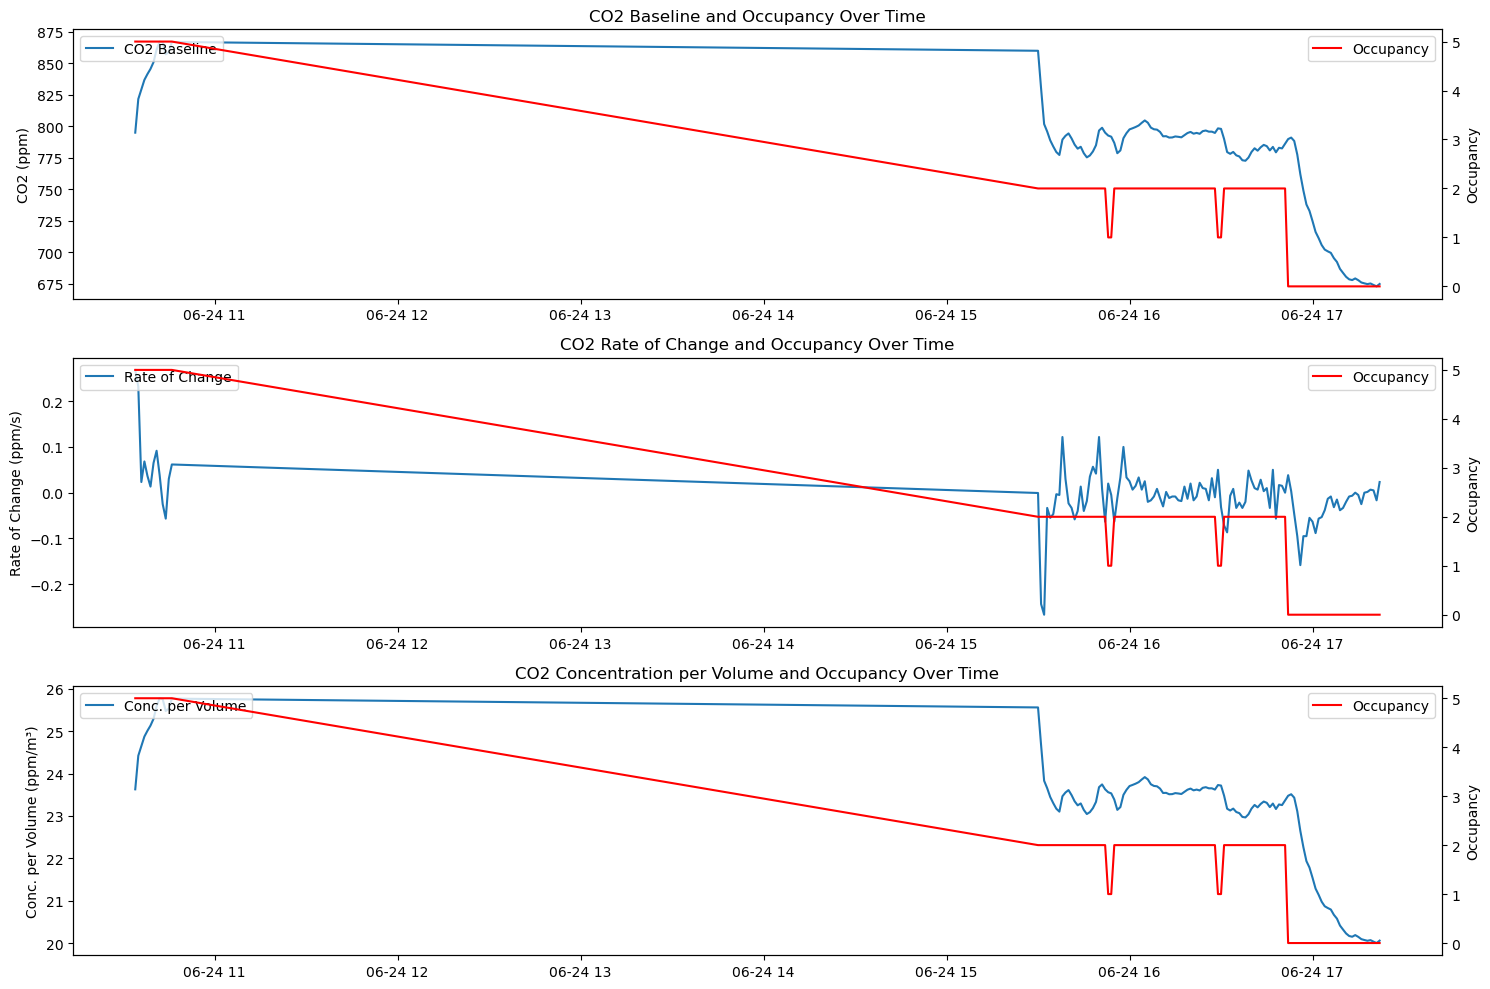

Regression Results:
Coefficient for Rate of Change: 5.7268
Coefficient for Concentration per Volume: 0.7617
Intercept: -15.7515
R-squared: 0.7509


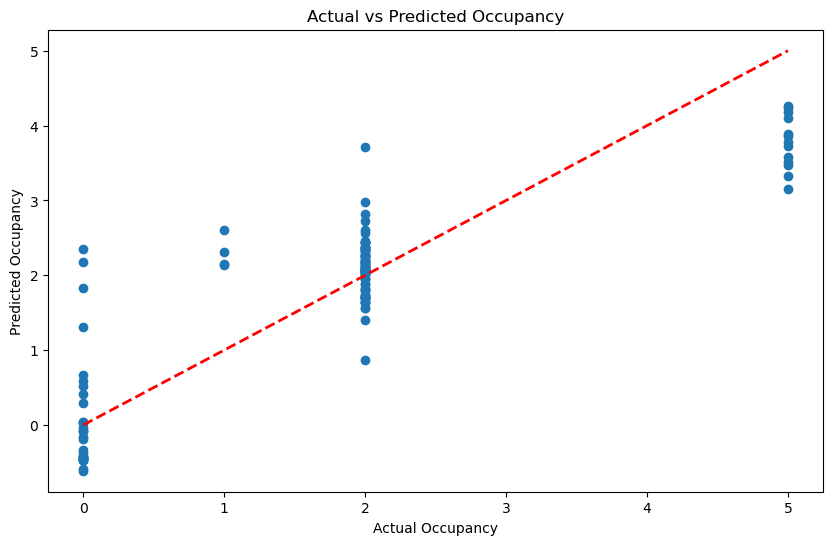

Nighttime CO2 Baseline: nan ppm


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

ROOM_VOLUME = 1188.25 * 0.0283168  # cubic feet to cubic meters
ROLLING_WINDOW = 5  # Adjust this value as needed
DELTA_TIME = 30  # Adjust this value as needed

occupancy_data = pd.read_csv('24th_occupancy_dataSheet1.csv', parse_dates=['Time'])
co2_data_pi1 = pd.read_csv('co2_data_24th_pi1.csv', parse_dates=['timestamp'])
co2_data_pi2 = pd.read_csv('co2_data_24th_pi2.csv', parse_dates=['timestamp'])

co2_data = pd.merge_asof(co2_data_pi1, co2_data_pi2, on='timestamp', suffixes=('_pi1', '_pi2'))
co2_data['co2_avg'] = (co2_data['co2_pi1'] + co2_data['co2_pi2']) / 2

co2_data['co2_baseline'] = co2_data['co2_avg'].rolling(window=ROLLING_WINDOW).mean()

# ppm/s
co2_data['co2_delta'] = co2_data['co2_baseline'].diff()
co2_data['time_delta'] = co2_data['timestamp'].diff().dt.total_seconds()
co2_data['rate_of_change'] = co2_data['co2_delta'] / co2_data['time_delta']

# ppm/m³
co2_data['conc_per_volume'] = co2_data['co2_baseline'] / ROOM_VOLUME

merged_data = pd.merge_asof(co2_data, occupancy_data, left_on='timestamp', right_on='Time')
merged_data = merged_data.replace([np.inf, -np.inf], np.nan).dropna()

# plots area:
plt.figure(figsize=(15, 10))

# CO2 baseline and occupancy
ax1 = plt.subplot(311)
ax1.plot(merged_data['timestamp'], merged_data['co2_baseline'], label='CO2 Baseline')
ax1.set_ylabel('CO2 (ppm)')
ax1.legend(loc='upper left')
ax2 = ax1.twinx()
ax2.plot(merged_data['timestamp'], merged_data['count'], 'r-', label='Occupancy')
ax2.set_ylabel('Occupancy')
ax2.legend(loc='upper right')
plt.title('CO2 Baseline and Occupancy Over Time')

# Rate of change and occupancy
ax3 = plt.subplot(312)
ax3.plot(merged_data['timestamp'], merged_data['rate_of_change'], label='Rate of Change')
ax3.set_ylabel('Rate of Change (ppm/s)')
ax3.legend(loc='upper left')
ax4 = ax3.twinx()
ax4.plot(merged_data['timestamp'], merged_data['count'], 'r-', label='Occupancy')
ax4.set_ylabel('Occupancy')
ax4.legend(loc='upper right')
plt.title('CO2 Rate of Change and Occupancy Over Time')

# Concentration per volume and occupancy
ax5 = plt.subplot(313)
ax5.plot(merged_data['timestamp'], merged_data['conc_per_volume'], label='Conc. per Volume')
ax5.set_ylabel('Conc. per Volume (ppm/m³)')
ax5.legend(loc='upper left')
ax6 = ax5.twinx()
ax6.plot(merged_data['timestamp'], merged_data['count'], 'r-', label='Occupancy')
ax6.set_ylabel('Occupancy')
ax6.legend(loc='upper right')
plt.title('CO2 Concentration per Volume and Occupancy Over Time')

plt.tight_layout()
plt.show()

# Regression analysis
X = merged_data[['rate_of_change', 'conc_per_volume']]
y = merged_data['count']

model = LinearRegression()
model.fit(X, y)
r_squared = r2_score(y, model.predict(X))

print(f"Regression Results:")
print(f"Coefficient for Rate of Change: {model.coef_[0]:.4f}")
print(f"Coefficient for Concentration per Volume: {model.coef_[1]:.4f}")
print(f"Intercept: {model.intercept_:.4f}")
print(f"R-squared: {r_squared:.4f}")

# Scatter plot of actual vs predicted occupancy
plt.figure(figsize=(10, 6))
plt.scatter(y, model.predict(X))
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Actual Occupancy')
plt.ylabel('Predicted Occupancy')
plt.title('Actual vs Predicted Occupancy')
plt.show()

# Calculate nighttime baseline // WIP // No data added yet.
night_hours = (merged_data['timestamp'].dt.hour >= 0) & (merged_data['timestamp'].dt.hour < 9)
nighttime_baseline = merged_data.loc[night_hours, 'co2_baseline'].mean()
print(f"Nighttime CO2 Baseline: {nighttime_baseline:.2f} ppm")

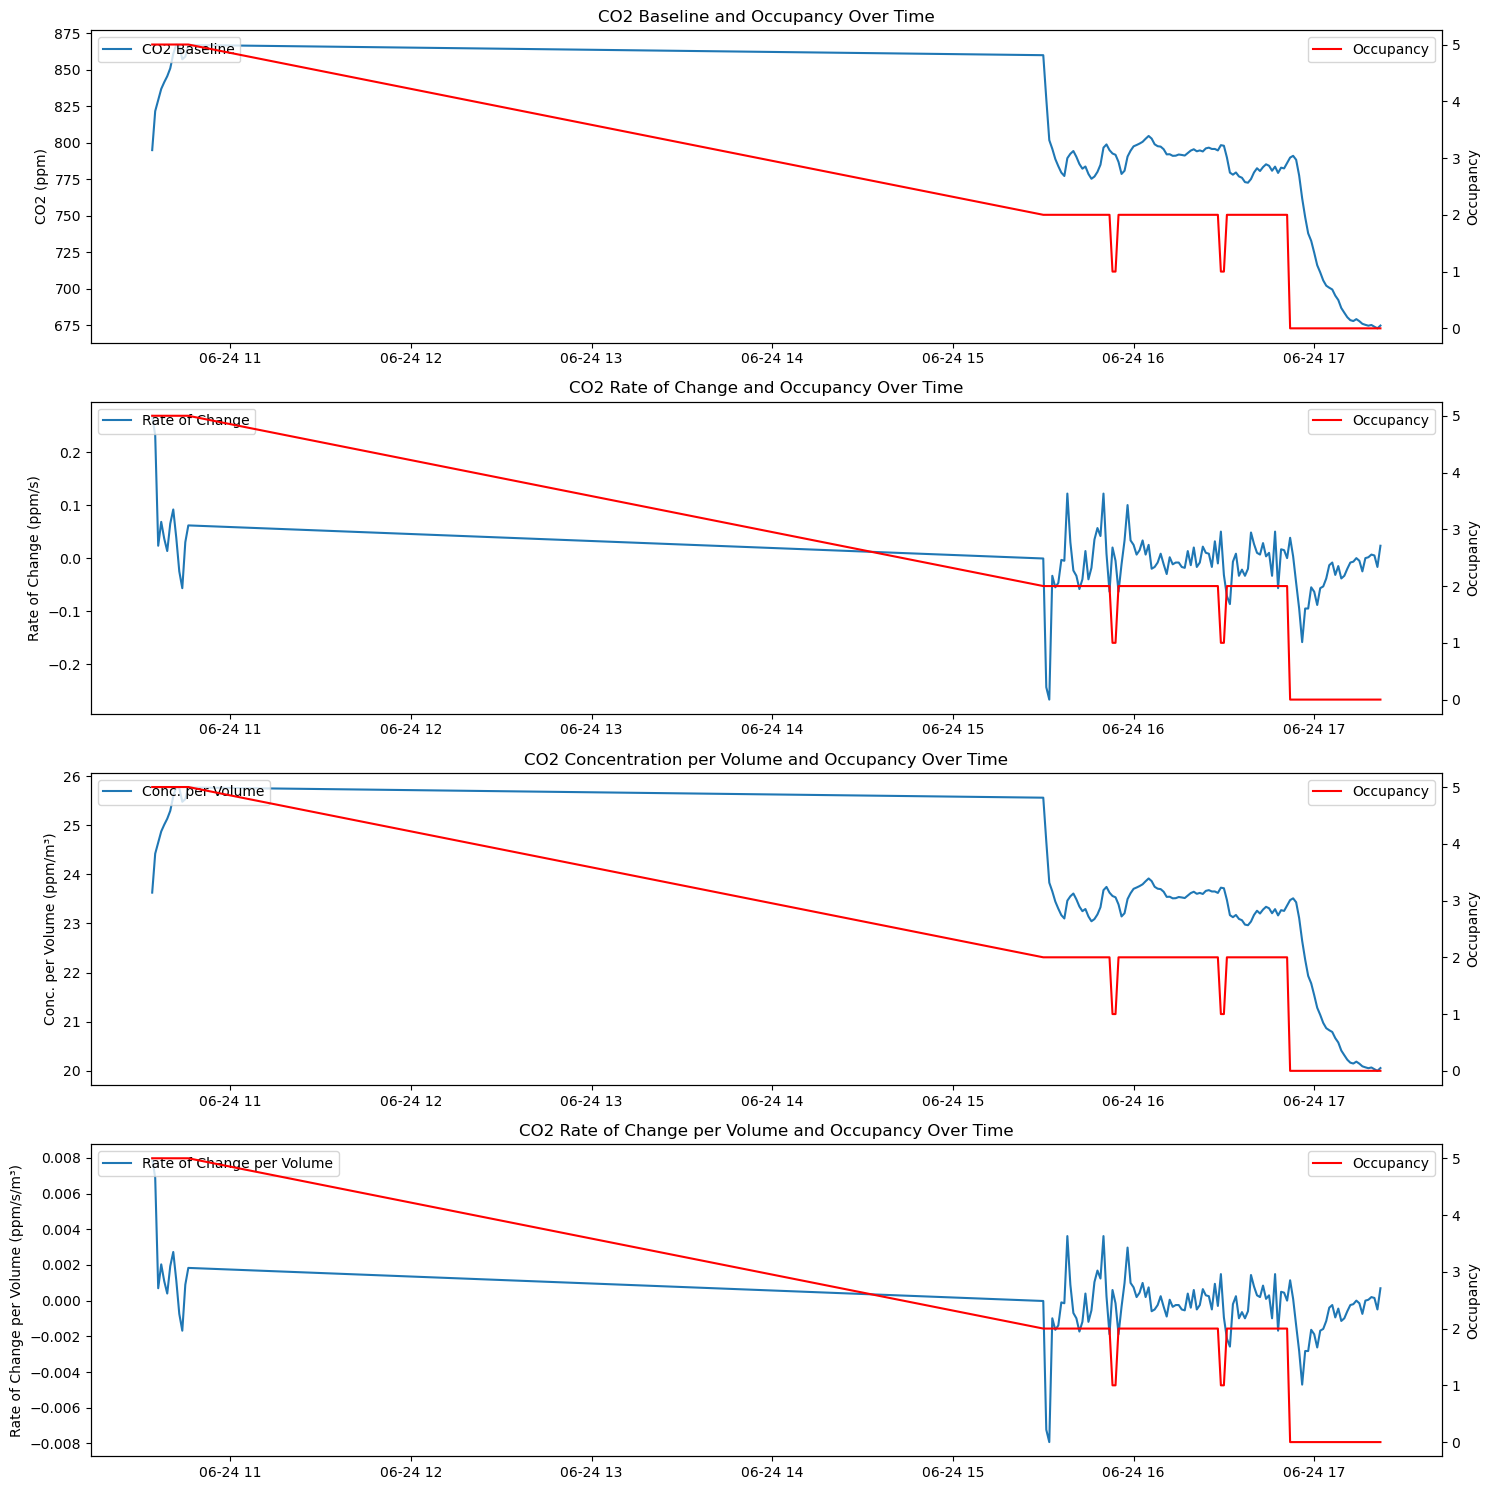

Regression Results:
Coefficient for Rate of Change: 5.7218
Coefficient for Concentration per Volume: 0.7617
Coefficient for Rate of Change per Volume: 0.1701
Intercept: -15.7515
R-squared: 0.7509


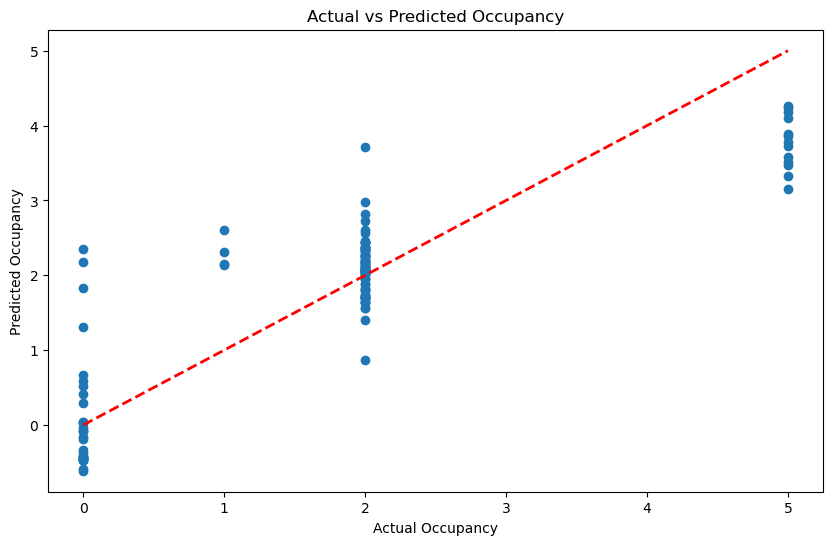

Nighttime CO2 Baseline: nan ppm


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

ROOM_VOLUME = 1188.25 * 0.0283168  # cubic feet to cubic meters
ROLLING_WINDOW = 5  # Adjust this value as needed
DELTA_TIME = 30  # Adjust this value as needed

occupancy_data = pd.read_csv('24th_occupancy_dataSheet1.csv', parse_dates=['Time'])
co2_data_pi1 = pd.read_csv('co2_data_24th_pi1.csv', parse_dates=['timestamp'])
co2_data_pi2 = pd.read_csv('co2_data_24th_pi2.csv', parse_dates=['timestamp'])

co2_data = pd.merge_asof(co2_data_pi1, co2_data_pi2, on='timestamp', suffixes=('_pi1', '_pi2'))
co2_data['co2_avg'] = (co2_data['co2_pi1'] + co2_data['co2_pi2']) / 2

co2_data['co2_baseline'] = co2_data['co2_avg'].rolling(window=ROLLING_WINDOW).mean()

# ppm/s
co2_data['co2_delta'] = co2_data['co2_baseline'].diff()
co2_data['time_delta'] = co2_data['timestamp'].diff().dt.total_seconds()
co2_data['rate_of_change'] = co2_data['co2_delta'] / co2_data['time_delta']

# ppm/m³
co2_data['conc_per_volume'] = co2_data['co2_baseline'] / ROOM_VOLUME

# ppm/s/m³
co2_data['rate_of_change_per_volume'] = co2_data['rate_of_change'] / ROOM_VOLUME

# Merge with occupancy data
merged_data = pd.merge_asof(co2_data, occupancy_data, left_on='timestamp', right_on='Time')

# Clean the data
merged_data = merged_data.replace([np.inf, -np.inf], np.nan).dropna()

# Visualize the data
plt.figure(figsize=(15, 15))

# CO2 baseline and occupancy
ax1 = plt.subplot(411)
ax1.plot(merged_data['timestamp'], merged_data['co2_baseline'], label='CO2 Baseline')
ax1.set_ylabel('CO2 (ppm)')
ax1.legend(loc='upper left')
ax2 = ax1.twinx()
ax2.plot(merged_data['timestamp'], merged_data['count'], 'r-', label='Occupancy')
ax2.set_ylabel('Occupancy')
ax2.legend(loc='upper right')
plt.title('CO2 Baseline and Occupancy Over Time')

# Rate of change and occupancy
ax3 = plt.subplot(412)
ax3.plot(merged_data['timestamp'], merged_data['rate_of_change'], label='Rate of Change')
ax3.set_ylabel('Rate of Change (ppm/s)')
ax3.legend(loc='upper left')
ax4 = ax3.twinx()
ax4.plot(merged_data['timestamp'], merged_data['count'], 'r-', label='Occupancy')
ax4.set_ylabel('Occupancy')
ax4.legend(loc='upper right')
plt.title('CO2 Rate of Change and Occupancy Over Time')

# Concentration per volume and occupancy
ax5 = plt.subplot(413)
ax5.plot(merged_data['timestamp'], merged_data['conc_per_volume'], label='Conc. per Volume')
ax5.set_ylabel('Conc. per Volume (ppm/m³)')
ax5.legend(loc='upper left')
ax6 = ax5.twinx()
ax6.plot(merged_data['timestamp'], merged_data['count'], 'r-', label='Occupancy')
ax6.set_ylabel('Occupancy')
ax6.legend(loc='upper right')
plt.title('CO2 Concentration per Volume and Occupancy Over Time')

# Rate of change per volume and occupancy
ax7 = plt.subplot(414)
ax7.plot(merged_data['timestamp'], merged_data['rate_of_change_per_volume'], label='Rate of Change per Volume')
ax7.set_ylabel('Rate of Change per Volume (ppm/s/m³)')
ax7.legend(loc='upper left')
ax8 = ax7.twinx()
ax8.plot(merged_data['timestamp'], merged_data['count'], 'r-', label='Occupancy')
ax8.set_ylabel('Occupancy')
ax8.legend(loc='upper right')
plt.title('CO2 Rate of Change per Volume and Occupancy Over Time')

plt.tight_layout()
plt.show()

# Regression analysis
X = merged_data[['rate_of_change', 'conc_per_volume', 'rate_of_change_per_volume']]
y = merged_data['count']
model = LinearRegression()
model.fit(X, y)
r_squared = r2_score(y, model.predict(X))

print(f"Regression Results:")
print(f"Coefficient for Rate of Change: {model.coef_[0]:.4f}")
print(f"Coefficient for Concentration per Volume: {model.coef_[1]:.4f}")
print(f"Coefficient for Rate of Change per Volume: {model.coef_[2]:.4f}")
print(f"Intercept: {model.intercept_:.4f}")
print(f"R-squared: {r_squared:.4f}")

# Scatter plot of actual vs predicted occupancy
plt.figure(figsize=(10, 6))
plt.scatter(y, model.predict(X))
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Actual Occupancy')
plt.ylabel('Predicted Occupancy')
plt.title('Actual vs Predicted Occupancy')
plt.show()

# WIP:
night_hours = (merged_data['timestamp'].dt.hour >= 0) & (merged_data['timestamp'].dt.hour < 9)
nighttime_baseline = merged_data.loc[night_hours, 'co2_baseline'].mean()
print(f"Nighttime CO2 Baseline: {nighttime_baseline:.2f} ppm")